In [1]:
pip install ltcn

Importing packages


In [51]:
import seaborn as sns
import miceforest as mf
import numpy as np
import pandas as pd
import keras
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.decomposition import PCA
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

Loading Data

In [87]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
myocardial_infarction_complications = fetch_ucirepo(id=579) 
  
# data (as pandas dataframes) 
X = myocardial_infarction_complications.data.features
Y = myocardial_infarction_complications.data.targets

Y.loc[Y.LET_IS == 0, "Lethal_outcome"] = 0 #"Alive"
Y.loc[Y.LET_IS != 0, "Lethal_outcome"] = 1 #"Complication leading to death"

y = Y.iloc[:,-1:]
y_target = y.astype(int)

y = pd.get_dummies(y).values

# metadata 
print(myocardial_infarction_complications.metadata) 
  
# variable information 
print(myocardial_infarction_complications.variables)

{'uci_id': 579, 'name': 'Myocardial infarction complications', 'repository_url': 'https://archive.ics.uci.edu/dataset/579/myocardial+infarction+complications', 'data_url': 'https://archive.ics.uci.edu/static/public/579/data.csv', 'abstract': 'Prediction of myocardial infarction complications', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1700, 'num_features': 111, 'feature_types': ['Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['FIBR_PREDS', 'PREDS_TAH', 'JELUD_TAH', 'FIBR_JELUD', 'A_V_BLOK', 'OTEK_LANC', 'RAZRIV', 'DRESSLER', 'ZSN', 'REC_IM', 'P_IM_STEN', 'LET_IS'], 'index_col': ['ID'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2020, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C53P5M', 'creators': ['S.E. Golovenkin', 'V.A. Shulman', 'D.A. Rossiev', 'P.A. Shesternya', 'S.Yu. Nikulina', 'Yu.V. Orlova', 'V.F. Voino-Yasenetsky'], 'intro_paper': {'tit


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [88]:
print(y_target)

      Lethal_outcome
0                  0
1                  0
2                  0
3                  0
4                  0
...              ...
1695               1
1696               1
1697               1
1698               1
1699               1

[1700 rows x 1 columns]


In [89]:
print(y)

[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]


One hot encoding target variable


In [90]:
#one hot encode y

# Convert to a NumPy array
y = np.array(y)

# Create a new array with two columns, where the second column is the complement of the first column
new_array = np.column_stack((y, 1 - y))

# Convert to dtype=uint8
new_array = new_array.astype(np.uint8)
y_encoded = new_array
# Print the resulting array
print(y_encoded)

[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]


In [91]:
print(y_encoded.shape)

(1700, 2)


In [92]:
# Get the column indices of all features
for idx, col in enumerate(X.columns):
    print(f"Column Name: {col}, Column Index: {idx}")

Column Name: AGE, Column Index: 0
Column Name: SEX, Column Index: 1
Column Name: INF_ANAM, Column Index: 2
Column Name: STENOK_AN, Column Index: 3
Column Name: FK_STENOK, Column Index: 4
Column Name: IBS_POST, Column Index: 5
Column Name: IBS_NASL, Column Index: 6
Column Name: GB, Column Index: 7
Column Name: SIM_GIPERT, Column Index: 8
Column Name: DLIT_AG, Column Index: 9
Column Name: ZSN_A, Column Index: 10
Column Name: nr_11, Column Index: 11
Column Name: nr_01, Column Index: 12
Column Name: nr_02, Column Index: 13
Column Name: nr_03, Column Index: 14
Column Name: nr_04, Column Index: 15
Column Name: nr_07, Column Index: 16
Column Name: nr_08, Column Index: 17
Column Name: np_01, Column Index: 18
Column Name: np_04, Column Index: 19
Column Name: np_05, Column Index: 20
Column Name: np_07, Column Index: 21
Column Name: np_08, Column Index: 22
Column Name: np_09, Column Index: 23
Column Name: np_10, Column Index: 24
Column Name: endocr_01, Column Index: 25
Column Name: endocr_02, Col

Dropping columns that are not useful

In [93]:
#Features concerning information after admission
data_dropped = X.drop(X.columns[[91, 92, 93, 98, 99, 100, 101, 102, 103]], axis=1)

In [94]:
#features missing more than x amount of missing values
data_dropped.drop(["KFK_BLOOD", "IBS_NASL", "D_AD_KBRIG", "S_AD_KBRIG"], axis=1, inplace=True) #Check two last added features effect

In [95]:
#percentage of missing data per column
percent_missing = data_dropped.isnull().sum() * 100 / len(data_dropped)
print(percent_missing.sort_values(ascending=False))

NOT_NA_KB     40.352941
LID_KB        39.823529
NA_KB         38.647059
NA_BLOOD      22.058824
GIPER_NA      22.058824
                ...    
zab_leg_03     0.411765
zab_leg_04     0.411765
INF_ANAM       0.235294
IM_PG_P        0.058824
SEX            0.000000
Length: 98, dtype: float64


In [62]:
print(X)

       AGE  SEX  INF_ANAM  STENOK_AN  FK_STENOK  IBS_POST   GB  SIM_GIPERT  \
0     77.0    1       2.0        1.0        1.0       2.0  3.0         0.0   
1     55.0    1       1.0        0.0        0.0       0.0  0.0         0.0   
2     52.0    1       0.0        0.0        0.0       2.0  2.0         0.0   
3     68.0    0       0.0        0.0        0.0       2.0  2.0         0.0   
4     60.0    1       0.0        0.0        0.0       2.0  3.0         0.0   
...    ...  ...       ...        ...        ...       ...  ...         ...   
1695  77.0    0       0.0        4.0        2.0       1.0  2.0         0.0   
1696  70.0    0       0.0        6.0        2.0       1.0  2.0         0.0   
1697  55.0    1       3.0        6.0        2.0       2.0  0.0         0.0   
1698  79.0    0       2.0        2.0        2.0       1.0  2.0         0.0   
1699  63.0    1       2.0        NaN        NaN       NaN  2.0         0.0   

      DLIT_AG  ZSN_A  ...  LID_KB  NITR_S  NA_R_1_n  NA_R_2_n  

In [96]:
X = data_dropped.values

In [99]:
print(X.shape)

(1700, 98)


In [100]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import OneHotEncoder

import numpy as np
import pandas as pd

import random
import os


        Parameters
        ----------
            T         :  {int}, default 20
                         Number of iterations to be performed
            phi       :  {float}, default 0.8
                         Amount of non-linearity during reasoning.
            method    :  {String}, default 'inverse'
                         Regression approach ('inverse', 'ridge')
            function  :  {String}, default 'sigmoid'
                         Activation function ('sigmoid', 'hyperbolic')
            alpha :      {float}, default 1.0E-4
                         Positive penalization for L2-regularization

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import OneHotEncoder

import numpy as np
import pandas as pd

import random
import os

from ltcn.LTCN import LTCN

Optimized LTCN model Without SMOTE

In [160]:
def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(42)
    np.random.seed(42)
    random.seed(42)

#How to use the random seed?

def kappa_scorer(Y_pred, Y):
    return cohen_kappa_score(np.argmax(Y, axis=1), np.argmax(Y_pred, axis=1))

train_errors = []
test_errors = []

n_folds = 5

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X, y_target)#y_target?

for train_index, test_index in skf.split(X, y_target):

    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = y_encoded[train_index], y_encoded[test_index]

    # Create kernel. 
    kds_train = mf.ImputationKernel(
    X_train,
    random_state=42
    )

    kds_test = mf.ImputationKernel( 
    X_test,
    random_state=42
    )

    #Check for imputed value performance!!
    kds_train.mice(iterations=5, n_estimators=50)
    kds_test.mice(iterations=5, n_estimators=50)

    # Return the completed dataset.
    X_train = kds_train.complete_data()
    X_test = kds_test.complete_data()

    model = LTCN()#method='inverse')

        # hyper-parameter tuning using grid search happens here!!
    #param_grid = {'function': ['sigmoid', 'tanh'], 'phi': np.arange(0.5, 1.0, 0.1),
                      #'T': [5, 10, 15],'alpha': [0, 1.0E-2, 1.0E+2]}
    
    param_grid = {'method': ["inverse", "ridge"] ,'function': ['sigmoid', 'hyperbolic'], 'phi': np.arange(0.2, 1.0, 0.2),
                  'T': [5, 10, 20, 40], 'alpha': [0.00001, 0.0001, 0.001, 0.01]}

    kappa = make_scorer(kappa_scorer)
    grid_clf = GridSearchCV(model, param_grid, scoring=kappa, cv=n_folds, n_jobs=-1, error_score='raise')
    grid_clf.fit(X_train, Y_train)

    Y_pred_train = grid_clf.predict(X_train)
    train_errors.append(cohen_kappa_score(np.argmax(Y_train, axis=1), np.argmax(Y_pred_train, axis=1)))

    Y_pred_test = grid_clf.predict(X_test)
    test_errors.append(cohen_kappa_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_test, axis=1)))

print(sum(train_errors) / len(train_errors), sum(test_errors) / len(test_errors))

#Runs for 2 hours

0.637822469266788 0.38364787037686393


In [111]:
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_test, axis=1))

0.8911764705882353

In [112]:
accuracy_score(np.argmax(Y_train, axis=1), np.argmax(Y_pred_train, axis=1))

0.9125

In [161]:
# Classification Report
class_report = classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred_test, axis=1), zero_division=0, digits=3)
print('Classification Report:\n', class_report)

Classification Report:
               precision    recall  f1-score   support

           0      0.737     0.509     0.602        55
           1      0.911     0.965     0.937       285

    accuracy                          0.891       340
   macro avg      0.824     0.737     0.770       340
weighted avg      0.882     0.891     0.883       340



Best LTCN Model Kappa Score 0.5415

In [162]:
best_model = grid_clf.best_estimator_
print(grid_clf.best_estimator_)

Y_pred_best = best_model.predict(X_test)

best_kappa_score = cohen_kappa_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best, axis=1))
print("Best model's Cohen's Kappa score:", best_kappa_score)

LTCN(T=10, alpha=1e-05, method='inverse', phi=0.2)
Best model's Cohen's Kappa score: 0.5415451895043731


In [171]:
roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best, axis=1))

0.7370015948963317

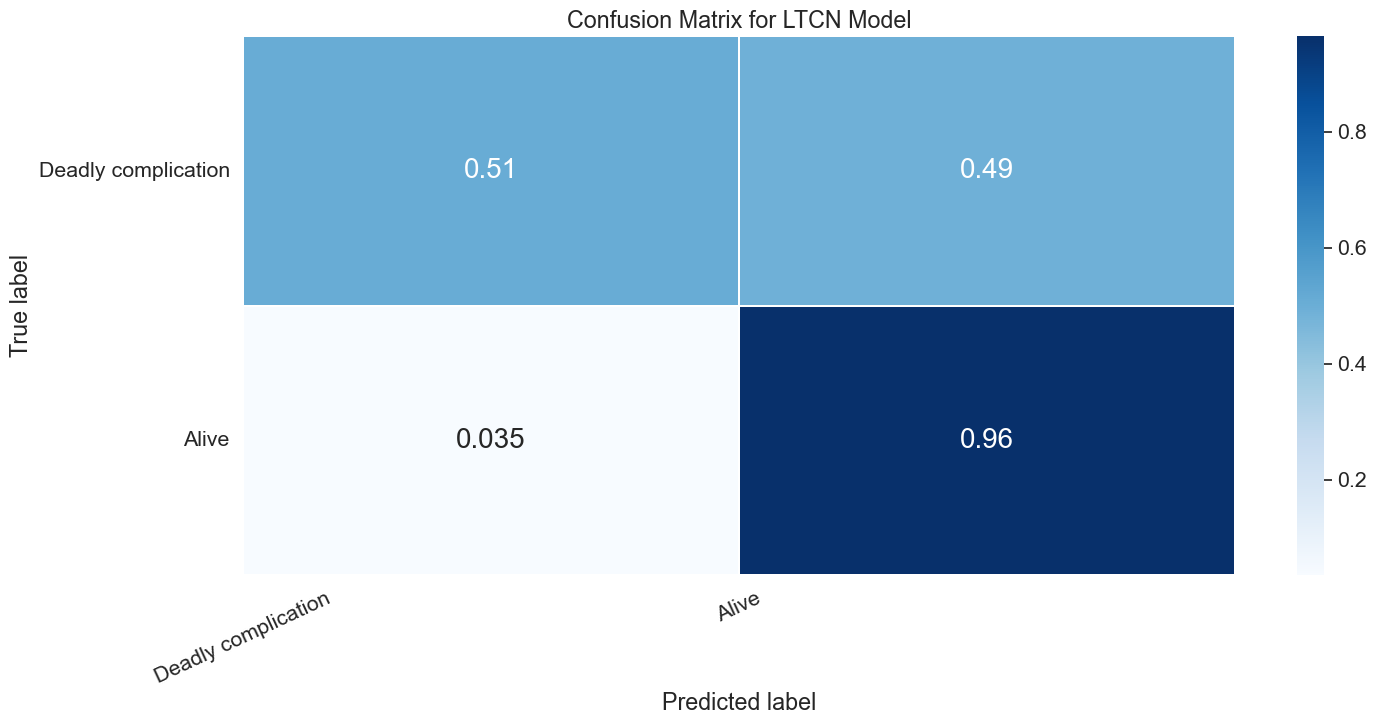

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get and reshape confusion matrix data
matrix = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best, axis=1))
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':20},
            cmap=plt.cm.Blues, linewidths=0.2)

# Add labels to the plot
class_names = ["Deadly complication", "Alive"]
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for LTCN Model')
plt.show()

In [119]:
# Classification Report
class_report = classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best, axis=1), zero_division=0, digits=3)
print('Classification Report:\n', class_report)

Classification Report:
               precision    recall  f1-score   support

           0      0.737     0.509     0.602        55
           1      0.911     0.965     0.937       285

    accuracy                          0.891       340
   macro avg      0.824     0.737     0.770       340
weighted avg      0.882     0.891     0.883       340



In [121]:
from sklearn.metrics import roc_auc_score
roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best, axis=1))

0.7370015948963317

In [177]:
recall_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best, axis=1))

0.9649122807017544

In [181]:
from sklearn.metrics import f1_score

f1_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best, axis=1))

0.9369676320272572

In [171]:
from imblearn.metrics import specificity_score
specificity_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best, axis=1), average='micro')

0.8911764705882353

In [122]:
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best, axis=1))

0.5539744936767675

In [123]:
from imblearn.metrics import sensitivity_score

sensitivity_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best, axis=1), average='micro')

0.8911764705882353

In [125]:
from imblearn.metrics import geometric_mean_score

geometric_mean_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best, axis=1), average='weighted')

0.7206951217991715

Optimized LTCN model + SMOTE

In [163]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss 
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTENC

def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(42)
    np.random.seed(42)
    random.seed(42)

def kappa_scorer(Y_pred, Y):
    return cohen_kappa_score(np.argmax(Y, axis=1), np.argmax(Y_pred, axis=1))

train_errors_smote = []
test_errors_smote = []

n_folds = 5

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X, y_target)#y_target?

errors = []
for train_index, test_index in skf.split(X, y_target):

    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = y[train_index], y[test_index]

    # Create kernel. 
    kds_train = mf.ImputationKernel(
    X_train,
    random_state=42
    )

    kds_test = mf.ImputationKernel( 
    X_test,
    random_state=42
    )

    #Check for imputed value performance!!
    kds_train.mice(iterations=5, n_estimators=50)
    kds_test.mice(iterations=5, n_estimators=50)

    # Return the completed dataset.
    X_train = kds_train.complete_data()
    X_test = kds_test.complete_data()

    rus = SMOTE(random_state=42)
    X_res, y_res = rus.fit_resample(X_train, Y_train)

    # Convert to a NumPy array
    y_res = np.array(y_res)
    Y_test = np.array(Y_test)

    # Create a new array with two columns, where the second column is the complement of the first column
    yres_array = np.column_stack((y_res, 1 - y_res))
    ytest_array = np.column_stack((Y_test, 1 - Y_test))

    # Convert to dtype=uint8
    yres_array = yres_array.astype(np.uint8)
    y_res = yres_array

    ytest_array = ytest_array.astype(np.uint8)
    Y_test = ytest_array
    # Print the resulting array
    print(y_res)
    print(Y_test)

      # Create the pipeline with the specified hyperparameters
    model_smote = LTCN()

        # hyper-parameter tuning using grid search happens here!!
    #param_grid = {'function': ['sigmoid', 'tanh'], 'phi': np.arange(0.5, 1.0, 0.1),
     #                'T': [5, 10, 15], 'alpha': [0, 1.0E-2, 1.0E+2]} 
    
    param_grid = {'method': ["inverse", "ridge"] ,'function': ['sigmoid', 'hyperbolic'], 'phi': np.arange(0.2, 1.0, 0.2),
                  'T': [5, 10, 20], 'alpha': [0.00001, 0.0001, 0.001, 0.01]}
    
    kappa = make_scorer(kappa_scorer)
    grid_clf_smote = GridSearchCV(model_smote, param_grid, scoring=kappa, cv=n_folds, n_jobs=-1, error_score='raise')
    grid_clf_smote.fit(X_res, y_res)

    Y_pred_train_smote = grid_clf_smote.predict(X_res)
    train_errors_smote.append(cohen_kappa_score(np.argmax(y_res, axis=1), np.argmax(Y_pred_train_smote, axis=1)))

    Y_pred_test_smote = grid_clf_smote.predict(X_test)
    test_errors_smote.append(cohen_kappa_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_test_smote, axis=1)))

print(sum(train_errors_smote) / len(train_errors_smote), sum(test_errors_smote) / len(test_errors_smote))

#runs for 13 min

[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]
[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]


In [167]:
best_model_smote = grid_clf_smote.best_estimator_
print(grid_clf_smote.best_estimator_)

Y_pred_best_smote = best_model_smote.predict(X_test)

best_kappa_score_smote = cohen_kappa_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best_smote, axis=1))
print("Best model's Cohen's Kappa score:", best_kappa_score_smote)

#try with T=5!! 0.50 with T=10

LTCN(T=5, phi=0.4)
Best model's Cohen's Kappa score: 0.491417361451692


In [172]:
roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best_smote, axis=1))

0.8196172248803827

In [174]:
recall_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best_smote, axis=1))

0.8210526315789474

In [183]:
f1_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best, axis=1))

0.9369676320272572

In [175]:
from sklearn.metrics import precision_score

precision_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best_smote, axis=1))

0.9590163934426229

In [131]:
print(Y_pred_best_smote)
print(Y_pred_best)

[[ 9.05036926e-02  9.09580231e-01]
 [ 7.07130432e-02  9.29389954e-01]
 [-3.01963806e-01  1.30214691e+00]
 [ 2.54110336e-01  7.46074677e-01]
 [-5.61275482e-02  1.05624771e+00]
 [ 8.09478760e-03  9.92111206e-01]
 [ 8.11233521e-02  9.18964386e-01]
 [ 2.06077576e-01  7.94094086e-01]
 [ 8.53767395e-02  9.14871216e-01]
 [-1.49724960e-01  1.14976120e+00]
 [ 1.09729767e-02  9.89223480e-01]
 [ 1.97344065e-01  8.02705288e-01]
 [ 1.64081573e-01  8.36093903e-01]
 [ 5.87806702e-02  9.41249847e-01]
 [ 6.00872040e-02  9.40115929e-01]
 [ 4.18881655e-01  5.81291914e-01]
 [ 1.23703003e-01  8.76655579e-01]
 [ 1.27579689e-01  8.72555733e-01]
 [ 3.93814087e-01  6.06300354e-01]
 [ 6.21891022e-02  9.37988281e-01]
 [-1.51351929e-01  1.15147400e+00]
 [ 6.82411194e-02  9.31961060e-01]
 [-3.69720459e-02  1.03705215e+00]
 [ 2.20198631e-02  9.78006363e-01]
 [-2.68192291e-01  1.26828766e+00]
 [ 3.68413925e-01  6.31832123e-01]
 [ 8.36219788e-02  9.16481018e-01]
 [ 8.27827454e-02  9.17385101e-01]
 [ 2.38895416e-02  9

In [168]:
# Classification Report
class_report_smote = classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best_smote, axis=1), zero_division=0, digits=3)
print('Classification Report:\n', class_report_smote)

Classification Report:
               precision    recall  f1-score   support

           0      0.469     0.818     0.596        55
           1      0.959     0.821     0.885       285

    accuracy                          0.821       340
   macro avg      0.714     0.820     0.740       340
weighted avg      0.880     0.821     0.838       340



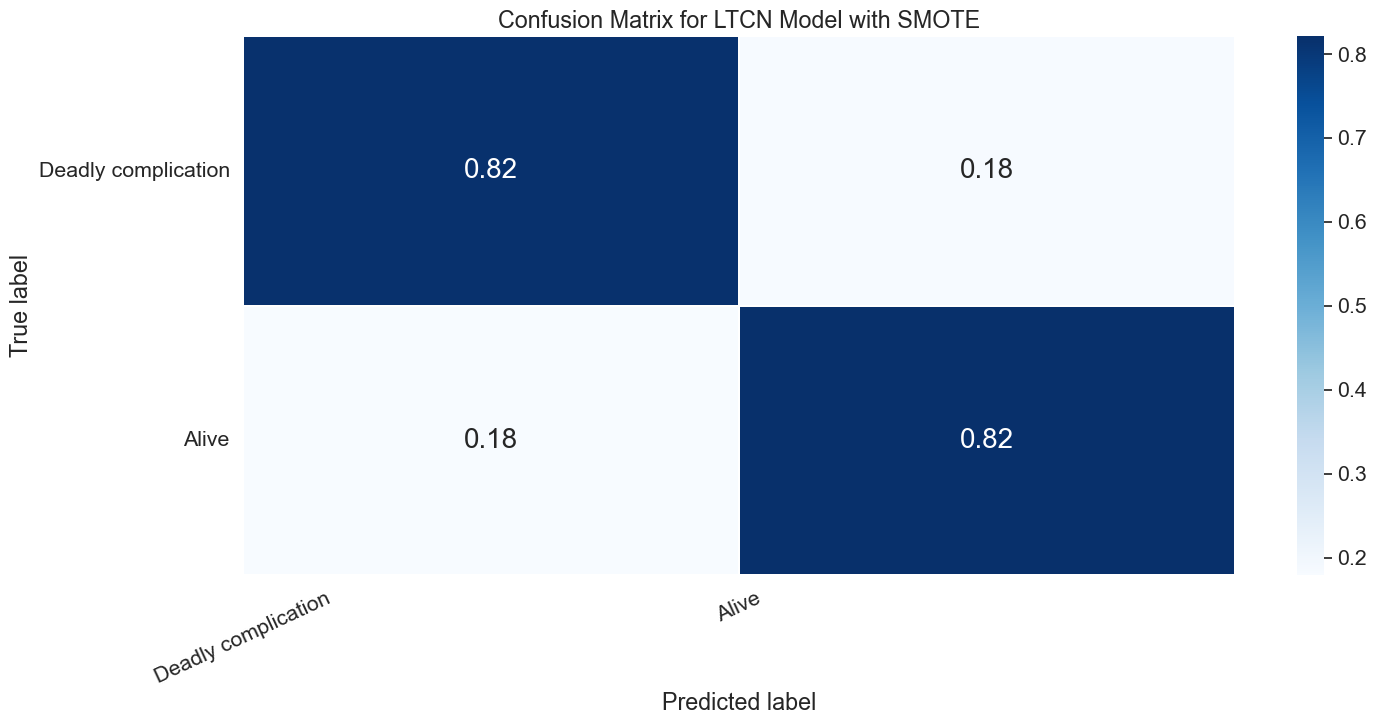

In [180]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get and reshape confusion matrix data
matrix = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best_smote, axis=1))
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':20},
            cmap=plt.cm.Blues, linewidths=0.2)

# Add labels to the plot
class_names = ["Deadly complication", "Alive"]
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for LTCN Model with SMOTE')
plt.show()

Trying other resampling techniques

ADASYN

In [142]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss 
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTENC

def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(42)
    np.random.seed(42)
    random.seed(42)

def kappa_scorer(Y_pred, Y):
    return cohen_kappa_score(np.argmax(Y, axis=1), np.argmax(Y_pred, axis=1))

train_errors_ada = []
test_errors_ada = []

n_folds = 5

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X, y_target)#y_target?

errors = []
for train_index, test_index in skf.split(X, y_target):

    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = y[train_index], y[test_index]

    # Create kernel. 
    kds_train = mf.ImputationKernel(
    X_train,
    random_state=42
    )

    kds_test = mf.ImputationKernel( 
    X_test,
    random_state=42
    )

    #Check for imputed value performance!!
    kds_train.mice(iterations=5, n_estimators=50)
    kds_test.mice(iterations=5, n_estimators=50)

    # Return the completed dataset.
    X_train = kds_train.complete_data()
    X_test = kds_test.complete_data()

    ada = ADASYN(random_state=42)
    X_ada, y_ada = ada.fit_resample(X_train, Y_train)

    # Convert to a NumPy array
    y_ada = np.array(y_ada)
    Y_test = np.array(Y_test)

    # Create a new array with two columns, where the second column is the complement of the first column
    yada_array = np.column_stack((y_ada, 1 - y_ada))
    ytest_array = np.column_stack((Y_test, 1 - Y_test))

    # Convert to dtype=uint8
    yada_array = yada_array.astype(np.uint8)
    y_ada = yada_array

    ytest_array = ytest_array.astype(np.uint8)
    Y_test = ytest_array
    # Print the resulting array
    print(y_ada)
    print(Y_test)

      # Create the pipeline with the specified hyperparameters
    model_ada = LTCN()

        # hyper-parameter tuning using grid search happens here!!
    #param_grid = {'function': ['sigmoid', 'tanh'], 'phi': np.arange(0.5, 1.0, 0.1),
     #                'T': [5, 10, 15], 'alpha': [0, 1.0E-2, 1.0E+2]} 
    
    param_grid = {'method': ["inverse", "ridge"] ,'function': ['sigmoid', 'hyperbolic'], 'phi': np.arange(0.2, 1.0, 0.2),
                  'T': [5, 10, 20], 'alpha': [0.00001, 0.0001, 0.001, 0.01]}
    
    kappa = make_scorer(kappa_scorer)
    grid_clf_ada = GridSearchCV(model_ada, param_grid, scoring=kappa, cv=n_folds, n_jobs=-1, error_score='raise')
    grid_clf_ada.fit(X_ada, y_ada)

    Y_pred_train_ada = grid_clf_ada.predict(X_ada)
    train_errors_ada.append(cohen_kappa_score(np.argmax(y_ada, axis=1), np.argmax(Y_pred_train_ada, axis=1)))

    Y_pred_test_ada = grid_clf_ada.predict(X_test)
    test_errors_ada.append(cohen_kappa_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_test_ada, axis=1)))

print(sum(train_errors_ada) / len(train_errors_ada), sum(test_errors_ada) / len(test_errors_ada))


[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]
[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]


In [145]:
best_model_ada = grid_clf_ada.best_estimator_
print(grid_clf_ada.best_estimator_)

Y_pred_best_ada = best_model_ada.predict(X_test)

best_kappa_score_ada = cohen_kappa_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best_ada, axis=1))
print("Best model's Cohen's Kappa score:", best_kappa_score_ada)

LTCN(T=5, alpha=1e-05, phi=0.2)
Best model's Cohen's Kappa score: 0.4863309352517986


In [146]:
# Classification Report
class_report_ada = classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best_ada, axis=1), zero_division=0, digits=3)
print('Classification Report:\n', class_report_ada)

Classification Report:
               precision    recall  f1-score   support

           0      0.460     0.836     0.594        55
           1      0.963     0.811     0.880       285

    accuracy                          0.815       340
   macro avg      0.711     0.823     0.737       340
weighted avg      0.881     0.815     0.834       340



In [156]:
roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best_ada, axis=1))

0.823444976076555

SMOTE ENN

In [147]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss 
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(42)
    np.random.seed(42)
    random.seed(42)

def kappa_scorer(Y_pred, Y):
    return cohen_kappa_score(np.argmax(Y, axis=1), np.argmax(Y_pred, axis=1))

train_errors_smen = []
test_errors_smen = []

n_folds = 5

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X, y_target)#y_target?

errors = []
for train_index, test_index in skf.split(X, y_target):

    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = y[train_index], y[test_index]

    # Create kernel. 
    kds_train = mf.ImputationKernel(
    X_train,
    random_state=42
    )

    kds_test = mf.ImputationKernel( 
    X_test,
    random_state=42
    )

    #Check for imputed value performance!!
    kds_train.mice(iterations=5, n_estimators=50)
    kds_test.mice(iterations=5, n_estimators=50)

    # Return the completed dataset.
    X_train = kds_train.complete_data()
    X_test = kds_test.complete_data()

    smen = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'), random_state=42)
    X_smen, y_smen = smen.fit_resample(X_train, Y_train)

    # Convert to a NumPy array
    y_smen = np.array(y_smen)
    Y_test = np.array(Y_test)

    # Create a new array with two columns, where the second column is the complement of the first column
    ysmen_array = np.column_stack((y_smen, 1 - y_smen))
    ytest_array = np.column_stack((Y_test, 1 - Y_test))

    # Convert to dtype=uint8
    ysmen_array = ysmen_array.astype(np.uint8)
    y_smen = ysmen_array

    ytest_array = ytest_array.astype(np.uint8)
    Y_test = ytest_array
    # Print the resulting array
    print(y_smen)
    print(Y_test)

      # Create the pipeline with the specified hyperparameters
    model_smen = LTCN()

        # hyper-parameter tuning using grid search happens here!!
    #param_grid = {'function': ['sigmoid', 'tanh'], 'phi': np.arange(0.5, 1.0, 0.1),
     #                'T': [5, 10, 15], 'alpha': [0, 1.0E-2, 1.0E+2]} 
    
    param_grid = {'method': ["inverse", "ridge"] ,'function': ['sigmoid', 'hyperbolic'], 'phi': np.arange(0.2, 1.0, 0.2),
                  'T': [5, 10, 20], 'alpha': [0.00001, 0.0001, 0.001, 0.01]}
    
    kappa = make_scorer(kappa_scorer)
    grid_clf_smen = GridSearchCV(model_smen, param_grid, scoring=kappa, cv=n_folds, n_jobs=-1, error_score='raise')
    grid_clf_smen.fit(X_smen, y_smen)

    Y_pred_train_smen = grid_clf_smen.predict(X_smen)
    train_errors_smen.append(cohen_kappa_score(np.argmax(y_smen, axis=1), np.argmax(Y_pred_train_smen, axis=1)))

    Y_pred_test_smen = grid_clf_smen.predict(X_test)
    test_errors_smen.append(cohen_kappa_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_test_smen, axis=1)))

print(sum(train_errors_smen) / len(train_errors_smen), sum(test_errors_smen) / len(test_errors_smen))

#runs for 13 min

[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]
[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]


In [170]:
best_model_smen = grid_clf_smen.best_estimator_
print(grid_clf_smen.best_estimator_)

Y_pred_best_smen = best_model_smen.predict(X_test)

best_kappa_score_smen = cohen_kappa_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best_smen, axis=1))
print("Best model's Cohen's Kappa score:", best_kappa_score_smen)

LTCN(T=5, alpha=0.01, method='inverse', phi=0.4)
Best model's Cohen's Kappa score: 0.2843674632755975


In [149]:
# Classification Report
class_report_smen = classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best_smen, axis=1), zero_division=0, digits=3)
print('Classification Report:\n', class_report_smen)

Classification Report:
               precision    recall  f1-score   support

           0      0.325     0.691     0.442        55
           1      0.924     0.723     0.811       285

    accuracy                          0.718       340
   macro avg      0.624     0.707     0.626       340
weighted avg      0.827     0.718     0.751       340



In [155]:
roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best_smen, axis=1))

0.7068580542264753

SMOTE Tomek

In [150]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss 
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import EditedNearestNeighbours

def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(42)
    np.random.seed(42)
    random.seed(42)

def kappa_scorer(Y_pred, Y):
    return cohen_kappa_score(np.argmax(Y, axis=1), np.argmax(Y_pred, axis=1))

train_errors_tmk = []
test_errors_tmk = []

n_folds = 5

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X, y_target)#y_target?

errors = []
for train_index, test_index in skf.split(X, y_target):

    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = y[train_index], y[test_index]

    # Create kernel. 
    kds_train = mf.ImputationKernel(
    X_train,
    random_state=42
    )

    kds_test = mf.ImputationKernel( 
    X_test,
    random_state=42
    )

    #Check for imputed value performance!!
    kds_train.mice(iterations=5, n_estimators=50)
    kds_test.mice(iterations=5, n_estimators=50)

    # Return the completed dataset.
    X_train = kds_train.complete_data()
    X_test = kds_test.complete_data()

    tmk = SMOTETomek(random_state=42)
    X_tmk, y_tmk = tmk.fit_resample(X_train, Y_train)

    # Convert to a NumPy array
    y_tmk = np.array(y_tmk)
    Y_test = np.array(Y_test)

    # Create a new array with two columns, where the second column is the complement of the first column
    ytmk_array = np.column_stack((y_tmk, 1 - y_tmk))
    ytest_array = np.column_stack((Y_test, 1 - Y_test))

    # Convert to dtype=uint8
    ytmk_array = ytmk_array.astype(np.uint8)
    y_tmk = ytmk_array

    ytest_array = ytest_array.astype(np.uint8)
    Y_test = ytest_array
    # Print the resulting array
    print(y_tmk)
    print(Y_test)

      # Create the pipeline with the specified hyperparameters
    model_tmk = LTCN()

        # hyper-parameter tuning using grid search happens here!!
    #param_grid = {'function': ['sigmoid', 'tanh'], 'phi': np.arange(0.5, 1.0, 0.1),
     #                'T': [5, 10, 15], 'alpha': [0, 1.0E-2, 1.0E+2]} 
    
    param_grid = {'method': ["inverse", "ridge"] ,'function': ['sigmoid', 'hyperbolic'], 'phi': np.arange(0.2, 1.0, 0.2),
                  'T': [5, 10, 20], 'alpha': [0.00001, 0.0001, 0.001, 0.01]}
    
    kappa = make_scorer(kappa_scorer)
    grid_clf_tmk = GridSearchCV(model_tmk, param_grid, scoring=kappa, cv=n_folds, n_jobs=-1, error_score='raise')
    grid_clf_tmk.fit(X_tmk, y_tmk)

    Y_pred_train_tmk = grid_clf_tmk.predict(X_tmk)
    train_errors_tmk.append(cohen_kappa_score(np.argmax(y_tmk, axis=1), np.argmax(Y_pred_train_tmk, axis=1)))

    Y_pred_test_tmk = grid_clf_tmk.predict(X_test)
    test_errors_tmk.append(cohen_kappa_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_test_tmk, axis=1)))

print(sum(train_errors_tmk) / len(train_errors_tmk), sum(test_errors_tmk) / len(test_errors_tmk))

#runs for 13 min

[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]
[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]


In [151]:
best_model_tmk = grid_clf_tmk.best_estimator_
print(grid_clf_tmk.best_estimator_)

Y_pred_best_tmk = best_model_tmk.predict(X_test)

best_kappa_score_tmk = cohen_kappa_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best_tmk, axis=1))
print("Best model's Cohen's Kappa score:", best_kappa_score_tmk)

LTCN(T=5, alpha=1e-05, function='hyperbolic', phi=0.4)
Best model's Cohen's Kappa score: 0.4466091245376078


In [152]:
# Classification Report
class_report_tmk = classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best_tmk, axis=1), zero_division=0, digits=3)
print('Classification Report:\n', class_report_tmk)

Classification Report:
               precision    recall  f1-score   support

           0      0.442     0.764     0.560        55
           1      0.947     0.814     0.875       285

    accuracy                          0.806       340
   macro avg      0.695     0.789     0.718       340
weighted avg      0.865     0.806     0.824       340



In [154]:
roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best_tmk, axis=1))

0.7888357256778309

Random Undersampling

In [138]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss 
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTENC

def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(42)
    np.random.seed(42)
    random.seed(42)

def kappa_scorer(Y_pred, Y):
    return cohen_kappa_score(np.argmax(Y, axis=1), np.argmax(Y_pred, axis=1))

train_errors_rus = []
test_errors_rus = []

n_folds = 5

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X, y_target)#y_target?

errors = []
for train_index, test_index in skf.split(X, y_target):

    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = y[train_index], y[test_index]

    # Create kernel. 
    kds_train = mf.ImputationKernel(
    X_train,
    random_state=42
    )

    kds_test = mf.ImputationKernel( 
    X_test,
    random_state=42
    )

    #Check for imputed value performance!!
    kds_train.mice(iterations=5, n_estimators=50)
    kds_test.mice(iterations=5, n_estimators=50)

    # Return the completed dataset.
    X_train = kds_train.complete_data()
    X_test = kds_test.complete_data()

    rus = RandomUnderSampler(random_state=42)
    X_rus, y_rus = rus.fit_resample(X_train, Y_train)

    # Convert to a NumPy array
    y_rus = np.array(y_rus)
    Y_test = np.array(Y_test)

    # Create a new array with two columns, where the second column is the complement of the first column
    yrus_array = np.column_stack((y_rus, 1 - y_rus))
    ytest_array = np.column_stack((Y_test, 1 - Y_test))

    # Convert to dtype=uint8
    yrus_array = yrus_array.astype(np.uint8)
    y_rus = yrus_array

    ytest_array = ytest_array.astype(np.uint8)
    Y_test = ytest_array
    # Print the resulting array
    print(y_rus)
    print(Y_test)

      # Create the pipeline with the specified hyperparameters
    model_rus = LTCN()

        # hyper-parameter tuning using grid search happens here!!
    #param_grid = {'function': ['sigmoid', 'tanh'], 'phi': np.arange(0.5, 1.0, 0.1),
     #                'T': [5, 10, 15], 'alpha': [0, 1.0E-2, 1.0E+2]} 
    
    param_grid = {'method': ["inverse", "ridge"] ,'function': ['sigmoid', 'hyperbolic'], 'phi': np.arange(0.2, 1.0, 0.2),
                  'T': [5, 10, 20], 'alpha': [0.00001, 0.0001, 0.001, 0.01]}
    
    kappa = make_scorer(kappa_scorer)
    grid_clf_rus = GridSearchCV(model_rus, param_grid, scoring=kappa, cv=n_folds, n_jobs=-1, error_score='raise')
    grid_clf_rus.fit(X_rus, y_rus)

    Y_pred_train_rus = grid_clf_rus.predict(X_rus)
    train_errors_rus.append(cohen_kappa_score(np.argmax(y_rus, axis=1), np.argmax(Y_pred_train_rus, axis=1)))

    Y_pred_test_rus = grid_clf_rus.predict(X_test)
    test_errors_rus.append(cohen_kappa_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_test_rus, axis=1)))

print(sum(train_errors_rus) / len(train_errors_rus), sum(test_errors_rus) / len(test_errors_rus))

#runs for 13 min

[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]

In [139]:
best_model_rus = grid_clf_rus.best_estimator_
print(grid_clf_rus.best_estimator_)

Y_pred_best_rus = best_model_rus.predict(X_test)

best_kappa_score_rus = cohen_kappa_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best_rus, axis=1))
print("Best model's Cohen's Kappa score:", best_kappa_score_rus)


LTCN(T=5, alpha=0.001, phi=0.2)
Best model's Cohen's Kappa score: 0.35626876010159314


In [140]:
# Classification Report
class_report_rus = classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best_rus, axis=1), zero_division=0, digits=3)
print('Classification Report:\n', class_report_rus)

Classification Report:
               precision    recall  f1-score   support

           0      0.374     0.727     0.494        55
           1      0.936     0.765     0.842       285

    accuracy                          0.759       340
   macro avg      0.655     0.746     0.668       340
weighted avg      0.845     0.759     0.785       340



In [158]:
roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_best_rus, axis=1))

0.7460925039872409

Imputation before for loop works the same right?

In [ ]:
# Imputation before the loop
kds = mf.ImputationKernel(X, random_state=42)
kds.mice(iterations=5, n_estimators=50)
X_imputed = kds.complete_data()

# Define cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X_imputed, y_target)

# Lists to store results
train_errors = []
test_errors = []

# Loop through folds
for train_index, test_index in skf.split(X_imputed, y_target):
    X_train, X_test = X_imputed[train_index], X_imputed[test_index]
    Y_train, Y_test = y_hope[train_index], y_hope[test_index]

    model = LTCN(method='inverse')

    rus = SMOTE(random_state=42) 
    X_res, y_res = rus.fit_resample(X_train, Y_train) #Apply SMOTE on original data and one hot encode after

    # Create the pipeline with the specified hyperparameters
    #LTCN_pipeline = imbpipeline(steps=[
    #["smote", SMOTE(random_state=42)],
    #["ltcn_classifier", LTCN()]])

        # hyper-parameter tuning using grid search happens here!!
    param_grid = {'ltcn_classifier__function': ['sigmoid', 'tanh'], 'ltcn_classifier__phi': np.arange(0.5, 1.0, 0.1),
                     'ltcn_classifier__T': [5, 10, 15]}#, 'ltcn_classifier__alpha': [0, 1.0E-2, 1.0E+2]} 


             # Convert to a NumPy array
    Y_train = np.array(Y_train)

    # Create a new array with two columns, where the second column is the complement of the first column
    ytrain_array = np.column_stack((Y_train, 1 - Y_train))

    # Convert to dtype=uint8
    ytrain_array = ytrain_array.astype(np.uint8)
    y_y_train = ytrain_array
    # Print the resulting array
    print(Y_train)
    
    kappa = make_scorer(kappa_scorer)
    grid_clf = GridSearchCV(model, param_grid, scoring=kappa, cv=n_folds, n_jobs=-1, error_score='raise')
    grid_clf.fit(X_res, y_res)

    Y_pred_train = grid_clf.predict(X_res)
    train_errors.append(cohen_kappa_score(np.argmax(y_res, axis=1), np.argmax(Y_pred_train, axis=1)))

    Y_pred_test = grid_clf.predict(X_test)
    test_errors.append(cohen_kappa_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_test, axis=1)))

print(sum(train_errors) / len(train_errors), sum(test_errors) / len(test_errors))

In [141]:
# Classification Report
class_report = classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred_test, axis=1), zero_division=0, digits=3)
print('Classification Report:\n', class_report)

Classification Report:
               precision    recall  f1-score   support

           0      0.714     0.463     0.562        54
           1      0.905     0.965     0.934       286

    accuracy                          0.885       340
   macro avg      0.810     0.714     0.748       340
weighted avg      0.875     0.885     0.875       340

